In [3]:
import matplotlib.pyplot as plt
from typing import List, Optional
import tensorflow as tf
import sys
sys.path.append('./src')
from autoencoder import Autoencoder
from SINDY import sindy_library_tf
from HIFF import generate_training_sat


In [4]:
# generate the trainig set 
print("[INFO] generating trainnig dataset...")
(trainX, trainY) = generate_training_sat(32, 300)

# generate the test set 
print("[INFO] generating testing dataset...")
(testX, testY) = generate_training_sat(32,60)

[INFO] generating trainnig dataset...
[INFO] generating testing dataset...


Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye [(None, 32)]              0         
_________________________________________________________________
fucku_0_dropout (Dropout)    (None, 32)                0         
_________________________________________________________________
fucku_0 (Dense)              (None, 25)                825       
_________________________________________________________________
decoder_0 (DenseTranspose)   (None, 32)                857       
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
Train step
Train step
60/60 [==============================] - 1s 3ms/step - loss: 0.2792
Epoch 2/20
60/60 [==============================] - 0s 4ms/step - loss: 0.1974
Epoch 3/20
60/60 [==============================] - 0s 3ms/step - loss: 0.1442

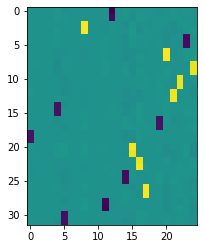

In [29]:
epochs = 20
batch_size = 5
# "layers_params" : [{"l1": 0.001, "l2" : 0.0, "dropout" : 0.2}, {"l1" : 0.001}],

model = Autoencoder([32, 25], ekwargs = {
        "name" : "fucku",
        "layers_params" : [{"l1": 0.001, "l2" : 0.0, "dropout" : 0.2}, {"l1" : 0.001}],
        'layers_default_params' : {
        'l1' : 0.001, 
        'l2' : 0.0, 
        'dropout' : 0.2, 
        'activation' : "tanh",
        'kernel_initializer' : tf.keras.initializers.RandomNormal(stddev=0.01),
        'bias_initializer' : tf.keras.initializers.Zeros()
        },
})
model.build_graph().summary()
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
        loss="mse")

model.fit(trainY, trainY, 
epochs = epochs, 
batch_size = batch_size, 
verbose = 1)

plt.imshow(model.encoder.weights[0].numpy())

In [25]:
model = Autoencoder([32, 25], ekwargs = {
        "name" : "fucku",
        "layers_params" : [{"l1": 0.001, "l2" : 0.0, "dropout" : 0.2}, {"l1" : 0.001}],
        'layers_default_params' : {
        'l1' : 0.001, 
        'l2' : 0.0, 
        'dropout' : 0.2, 
        'activation' : "tanh",
        'kernel_initializer' : tf.keras.initializers.RandomNormal(stddev=0.01),
        'bias_initializer' : tf.keras.initializers.Zeros()
        },
})
model.build_graph().summary()
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
        loss="mse")

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
autoencoder_input (InputLaye [(None, 32)]              0         
_________________________________________________________________
fucku_0_dropout (Dropout)    (None, 32)                0         
_________________________________________________________________
fucku_0 (Dense)              (None, 25)                825       
_________________________________________________________________
decoder_0 (DenseTranspose)   (None, 32)                857       
Total params: 857
Trainable params: 857
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((trainY, trainY))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((testY, testY))
val_dataset = val_dataset.batch(batch_size)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)


In [36]:
params = {}
params['coefficient_initialization'] = tf.keras.initializers.GlorotUniform()(shape = (2,2))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-1.0958582 ,  0.06148767],
       [-0.80121917, -0.8994139 ]], dtype=float32)>

- network - finished
- loss - still to code up
- optimizer - set by default 
- refinement optimizer - not implemented yet
- saver - to add in the future with custom callback (see custom models + layers - overide seralization in thesea autoencoder + encoder + decoder)

In [19]:
import time

loss_fn = tf.keras.losses.MeanSquaredError()
train_acc_metric = tf.keras.metrics.Mean()
val_acc_metric = tf.keras.metrics.Mean()

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        # Update val metrics
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 0.5472
Seen so far: 5 samples
Training acc over epoch: 0.7507
Validation acc: 0.8672
Time taken: 1.32s

Start of epoch 1
Training loss (for one batch) at step 0: 0.1137
Seen so far: 5 samples
Training acc over epoch: 0.8635
Validation acc: 0.9153
Time taken: 1.31s

Start of epoch 2
Training loss (for one batch) at step 0: 0.0750
Seen so far: 5 samples
Training acc over epoch: 0.8707
Validation acc: 0.8861
Time taken: 0.77s

Start of epoch 3
Training loss (for one batch) at step 0: 0.0759
Seen so far: 5 samples
Training acc over epoch: 0.8774
Validation acc: 0.8932
Time taken: 0.76s

Start of epoch 4
Training loss (for one batch) at step 0: 0.0640
Seen so far: 5 samples
Training acc over epoch: 0.8823
Validation acc: 0.8798
Time taken: 1.35s

Start of epoch 5
Training loss (for one batch) at step 0: 0.0758
Seen so far: 5 samples
Training acc over epoch: 0.8976
Validation acc: 0.9183
Time taken: 0.75s

Start of epoch 6
Training l

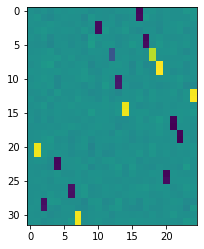

In [16]:
plt.imshow(model.encoder.weights[0].numpy())

In [30]:

class Autoencoder(tf.keras.Model):
    """
    Autoencoder
    Stack both encoder and decoder
    """
    def __init__(self, 
    widths : List[int] = [32,28,25], 
    ekwargs : Optional[dict] = {}, 
    dkwargs : Optional[dict] = {}, 
    **kwargs):
        if not ("name" in kwargs.keys()):
            kwargs["name"] = "autoencoder"

        super(Autoencoder, self).__init__(**kwargs)
        self.input_dim = widths[0]
        self.latent_dim = widths[-1]
        self.encoder = Encoder(widths, **ekwargs).build_graph()
        self.decoder = Decoder(self.encoder, **dkwargs).build_graph()
    
    def call(self, input):        
        x = self.encoder.layers[1](input)
        for layer in self.encoder.layers[2:] + self.decoder.layers[1:]:
            x = layer(x)
        return x
        
    """ def train_step(self, data):

        print("Train step")
        x, y = data
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    """
    def compile(self, **kwargs):
        super(Autoencoder, self).compile(**kwargs)

    def build_graph(self,):
        x = Input(shape=(self.input_dim, ), name = 'autoencoder_input')
        return tf.keras.Model(inputs = [x], outputs = self.call(x))

    def encode(self, input):
        return self.encoder(input)
    
    def decode(self, input):
        return self.decoder(input)

    def get_input_dim(self) -> int:
        return self.input_dim
    
    def get_latent_dim(self) -> int:
        return self.latent_dim

In [24]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Input, Dropout
from typing import List, Optional

def suplement_layers_params(architecture : List[int], layers_params : List[dict], layers_default_params : dict) -> dict:
    # add empty dicionaries to layers_params to corecponds to the encoding_layers_size size
    for _ in range(len(architecture) - len(layers_params)):
        layers_params.append({})
    return [{**layers_default_params, **x} for x in layers_params]

class DenseTranspose(tf.keras.layers.Layer):
    """
    Dense transpose layer from dense layer
    """
    def __init__(self, dense, activation = None, **kwargs):
        self.dense = dense 
        self.activation = tf.keras.activations.get(activation)
        super(DenseTranspose, self).__init__(**kwargs)
    def build(self, batch_input_shape):
        self.b = self.add_weight(name= "bias", shape = [ self.dense.input_shape[-1]], initializer = "zeros")
        self.w = self.dense.weights[0]
        super().build(batch_input_shape)
        
        
    def call(self, inputs):
        z = tf.linalg.matmul(inputs, self.w, transpose_b = True)
        return self.activation(z + self.b)
    
    def get_weights(self):
        return {"w": np.shape(tf.transpose(self.w))}    
    @property 
    def weights_transpose(self):
        return tf.transpose(self.dense.weights[0])


class Encoder(tf.keras.layers.Layer):
    """
    Encoder

    isFirstInputLayer - use input dimension only in Input Layer
    Kernel and bias are initialize by fresh instances of objects
    """
    def __init__(self, 
    widths : List[int] = [32,24], 
    isFirstInputLayer : Optional[bool] = True,
    layers_params : Optional[List[dict]] = [{}],
    layers_default_params : dict = {
        'l1' : 0.001, 
        'l2' : 0.0, 
        'dropout' : 0.2, 
        'activation' : "tanh",
        'kernel_initializer' : tf.keras.initializers.GlorotUniform(),
        'bias_initializer' : tf.keras.initializers.Zeros()
        },
    **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.latent_dim = widths[-1]
        self.input_dim = widths[0]
        self.layers = []
        
        if not ("name" in kwargs.keys()):
            kwargs["name"] = "encoder"

        layers_params = suplement_layers_params(widths, layers_params, layers_default_params)
        for (layer_index, layer_dim), layer_params_ in zip(
            enumerate(widths[1:] if isFirstInputLayer else widths), 
            layers_params):

            if layer_params_["dropout"] > 0.0:
                self.layers.append(Dropout(
                    layer_params_["dropout"],
                    name = kwargs["name"] + "_{}_dropout".format(layer_index)
                    ))
            # construct encoder layer 
            self.layers.append(Dense(
                    units = layer_dim,
                    activation= layer_params_["activation"],
                    kernel_initializer= layer_params_["kernel_initializer"].__class__(**layer_params_["kernel_initializer"].get_config()),
                    bias_initializer= layer_params_["bias_initializer"].__class__(**layer_params_["bias_initializer"].get_config()),
                    kernel_regularizer = tf.keras.regularizers.L1L2(
                        l1=layer_params_["l1"], 
                        l2=layer_params_["l2"]),
                    name = kwargs["name"] + "_{}".format(layer_index)))
        
    def call(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x


    def build_graph(self):
        x = Input(shape=(self.input_dim, ), name = 'encoder_input')
        return tf.keras.Model(inputs = [x], outputs = self.call(x))


class Decoder(tf.keras.layers.Layer):
    """
    Decoder

    isTranspose - use transposed layers from encoder. If False create fresh layers of the same size of encoder
    """

    """
    Add decoder documentation.
    """
    def __init__(self, 
    encoder : Encoder, 
    isTranspose : Optional[bool] = True,  
    layers_params : Optional[List[dict]] = [],
    layers_default_params : dict = {
        'l1' : 0.0, 
        'l2' : 0.0,
        'dropout' : 0.0, 
        'activation' : "tanh",
        'kernel_initializer' : tf.keras.initializers.GlorotUniform(),
        'bias_initializer' : tf.keras.initializers.Zeros()
        }, 
    **kwargs):

        super(Decoder, self).__init__(**kwargs)
        self.input_dim = encoder.weights[0].shape[-1]
        self.output_dim = encoder.weights[-1].shape[-1]
        self.layers = []

        if not ("name" in kwargs.keys()):
            kwargs["name"] = "decoder"

        layers_params = suplement_layers_params([x for x in encoder.layers[1:][::-1] if type(x) == Dense], layers_params, layers_default_params)

        if isTranspose:
            for layer_index, layer in enumerate([x for x in encoder.layers[1:][::-1] if type(x) == Dense]):
                self.layers.append(
                    DenseTranspose(
                        dense = layer,
                        name = kwargs["name"] + "_{}".format(layer_index)
                        )
                    )
        else:        
            for (layer_index, layer_dim), layer_params_ in zip(
                enumerate([x.input_shape[-1] for x in encoder.layers][1:][::-1]), 
                layers_params):
                
                if layer_params_["dropout"] > 0.0:
                    self.layers.append(Dropout(
                        layer_params_["dropout"],
                        name = kwargs["name"] + "_{}_dropout".format(layer_index)
                        ))

                self.layers.append(Dense(
                    units = layer_dim,
                    activation= layer_params_["activation"],
                    kernel_initializer= layer_params_["kernel_initializer"].__class__(**layer_params_["kernel_initializer"].get_config()),
                    bias_initializer= layer_params_["bias_initializer"].__class__(**layer_params_["bias_initializer"].get_config()),
                    kernel_regularizer = tf.keras.regularizers.L1L2(
                        l1=layer_params_["l1"], 
                        l2=layer_params_["l2"]),
                    name = kwargs["name"] + "_{}".format(layer_index)))
    
    """
    Add privileged training: training = None 
    """
    def call(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
        return x


    def build_graph(self):
        x = Input(shape=(self.output_dim, ), name = 'decoder_input')
        return tf.keras.Model(inputs = [x], outputs = self.call(x))

    """
    Overtide this method to enable serialization 
    """
    def get_config(self):
        pass